<a href="https://colab.research.google.com/github/fralfaro/MAT281/blob/main/docs/labs/lab_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MAT281 - Laboratorio N°10

**Objetivo**: Analizar y modelar series temporales de datos delictivos en Montreal, aplicando métodos estadísticos y de aprendizaje automático para la predicción.

> **Nota**: Puede ayudarse de algún asistente virtual como **ChatGPT, Gemini** u otros, así como del autocompletado de **Google Colab**, para avanzar en este laboratorio debido a su extensión.


### Conjunto de datos



<img src="https://svgsilh.com/svg/3350822.svg" width="350"  align="center"/>


El conjunto de datos **`interventionscitoyendo.csv`** proviene del *Service de police de la Ville de Montréal* (SPVM) y contiene el registro de todos los **actos delictivos ocurridos en Montreal entre 2015 y agosto de 2020**.

Cada incidente está clasificado en **categorías generales de delito** e incluye información contextual como la **ubicación geográfica**, la **fecha y hora** del suceso, así como otros atributos relevantes para el análisis.

Este dataset resulta especialmente útil para estudios de **series temporales**, ya que permite agrupar los delitos por intervalos de tiempo (días, semanas, meses) y analizar patrones de comportamiento delictual en la ciudad.

> **Nota**: Puede consultarse más información oficial en el [portal de datos abiertos de Montreal](https://donnees.montreal.ca/ville-de-montreal/actes-criminels).


In [5]:
# librerias

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX


# graficos incrustados
plt.style.use('fivethirtyeight')
%matplotlib inline

# parametros esteticos de seaborn
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (12, 4)})

In [6]:
# metrics


def mae(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute error (MAE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.abs(error).mean(), 4)


def mse(targets, predictions) -> float:
    """
    Calculo de la metrica: mean squared error (MSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round((error ** 2).mean(), 4)


def rmse(targets, predictions) -> float:
    """
    Calculo de la metrica: root mean squared error (RMSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.sqrt((error ** 2).mean()), 4)


# b) Percentage errors

def mape(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute percentage error (MAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets

    if any(x == 0 for x in targets):
        return np.inf
    else:
        return round(np.abs(error / targets).mean(),4)


def maape(targets, predictions) -> float:
    """
    Calculo de la metrica:  mean arctangent percentage error  (MAAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """

    error = predictions - targets

    if any((x, y) == (0, 0) for x, y in zip(predictions, targets)):
        return np.inf

    else:
        return round(np.arctan(np.abs(error / targets)).mean(),4)


def wmape(targets, predictions) -> float:
    """
    Calculo de la metrica:  weighted mean absolute percentage error (WMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.sum(targets)

    if sum_values == 0:
        return np.inf
    else:
        return round(np.abs(error).sum() / sum_values,4)


def mmape(targets, predictions) -> float:
    """
    Calculo de la metrica: modified mean absolute percentage error (MMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = np.abs(predictions - targets)
    denom = 1 + np.abs(targets)

    return round(np.mean(error / denom),4)


def smape(targets, predictions) -> float:
    """
    Calculo de la metrica: symmetric mean absolute percentage error (SMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.abs(predictions) + np.abs(targets)

    if any(x == 0 for x in sum_values):
        return np.inf

    else:
        return round(2 * np.mean(np.abs(error) / sum_values),4)

def summary_metrics(df) -> pd.DataFrame:
    """
    Aplicar las distintas metricas definidas
    :param df:  dataframe con las columnas: ['y','yhat']
    :return: dataframe con las metricas especificadas
    """
    df_result = pd.DataFrame()

    y_true = df['y']
    y_pred = df['yhat']

    df_result['mae'] = [round(mae(y_true, y_pred), 4)]
    df_result['mse'] = [round(mse(y_true, y_pred), 4)]
    df_result['rmse'] = [round(rmse(y_true, y_pred), 4)]

    df_result['mape'] = [round(mape(y_true, y_pred), 4)]
    df_result['maape'] = [round(maape(y_true, y_pred), 4)]
    df_result['wmape'] = [round(wmape(y_true, y_pred), 4)]
    df_result['mmape'] = [round(mmape(y_true, y_pred), 4)]
    df_result['smape'] = [round(smape(y_true, y_pred), 4)]

    # nombre del modelo por defecto
    #try:
    #    model = df['model'][0]
    #    df_result['model'] = [model]
    #except:
    #    df_result['model'] = ['---']

    return df_result

In [7]:
# read data

validate_categorie = [
  'Introduction', 'Méfait','Vol dans / sur véhicule à moteur', 'Vol de véhicule à moteur',
]

df = pd.read_csv("https://raw.githubusercontent.com/fralfaro/MAT281/main/docs/labs/data/interventionscitoyendo.csv", sep=",", encoding='latin-1')
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df = df.loc[lambda x: x['categorie'].isin(validate_categorie)]
df = df.sort_values(['categorie','date'])
df.head()

,categorie,date,quart,pdq,x,y,longitude,latitude
3462,Introduction,2015-01-01,jour,42.0,297210.375006,5.050179e+06,-73.597273,45.591480
8370,Introduction,2015-01-01,soir,13.0,297145.531007,5.032845e+06,-73.597834,45.435501
11968,Introduction,2015-01-01,nuit,8.0,289215.072000,5.036423e+06,-73.699308,45.467564
12763,Introduction,2015-01-01,soir,27.0,293203.472992,5.045436e+06,-73.648516,45.548740
13686,Introduction,2015-01-01,soir,44.0,298915.433995,5.046912e+06,-73.575381,45.562090


Como tenemos muchos datos por categoría a nivel de día, agruparemos a nivel de **semanas** y separaremos cada serie temporal.

In [8]:
cols = ['date','pdq']
y_s1 = df.loc[lambda x: x.categorie == validate_categorie[0] ][cols].set_index('date').resample('W').mean()
y_s2 = df.loc[lambda x: x.categorie == validate_categorie[1] ][cols].set_index('date').resample('W').mean()
y_s3 = df.loc[lambda x: x.categorie == validate_categorie[2] ][cols].set_index('date').resample('W').mean()
y_s4 = df.loc[lambda x: x.categorie == validate_categorie[3] ][cols].set_index('date').resample('W').mean()



El objetivo de este laboratorio es realizar un **análisis integral** del conjunto de datos, aplicando técnicas de visualización y modelado de series temporales. Para ello, se deben abordar las siguientes tareas:

1. **Visualizar las series temporales** \$y\_{si}, ; i=1,2,3,4\$, generando gráficos que permitan identificar patrones, tendencias y estacionalidades.



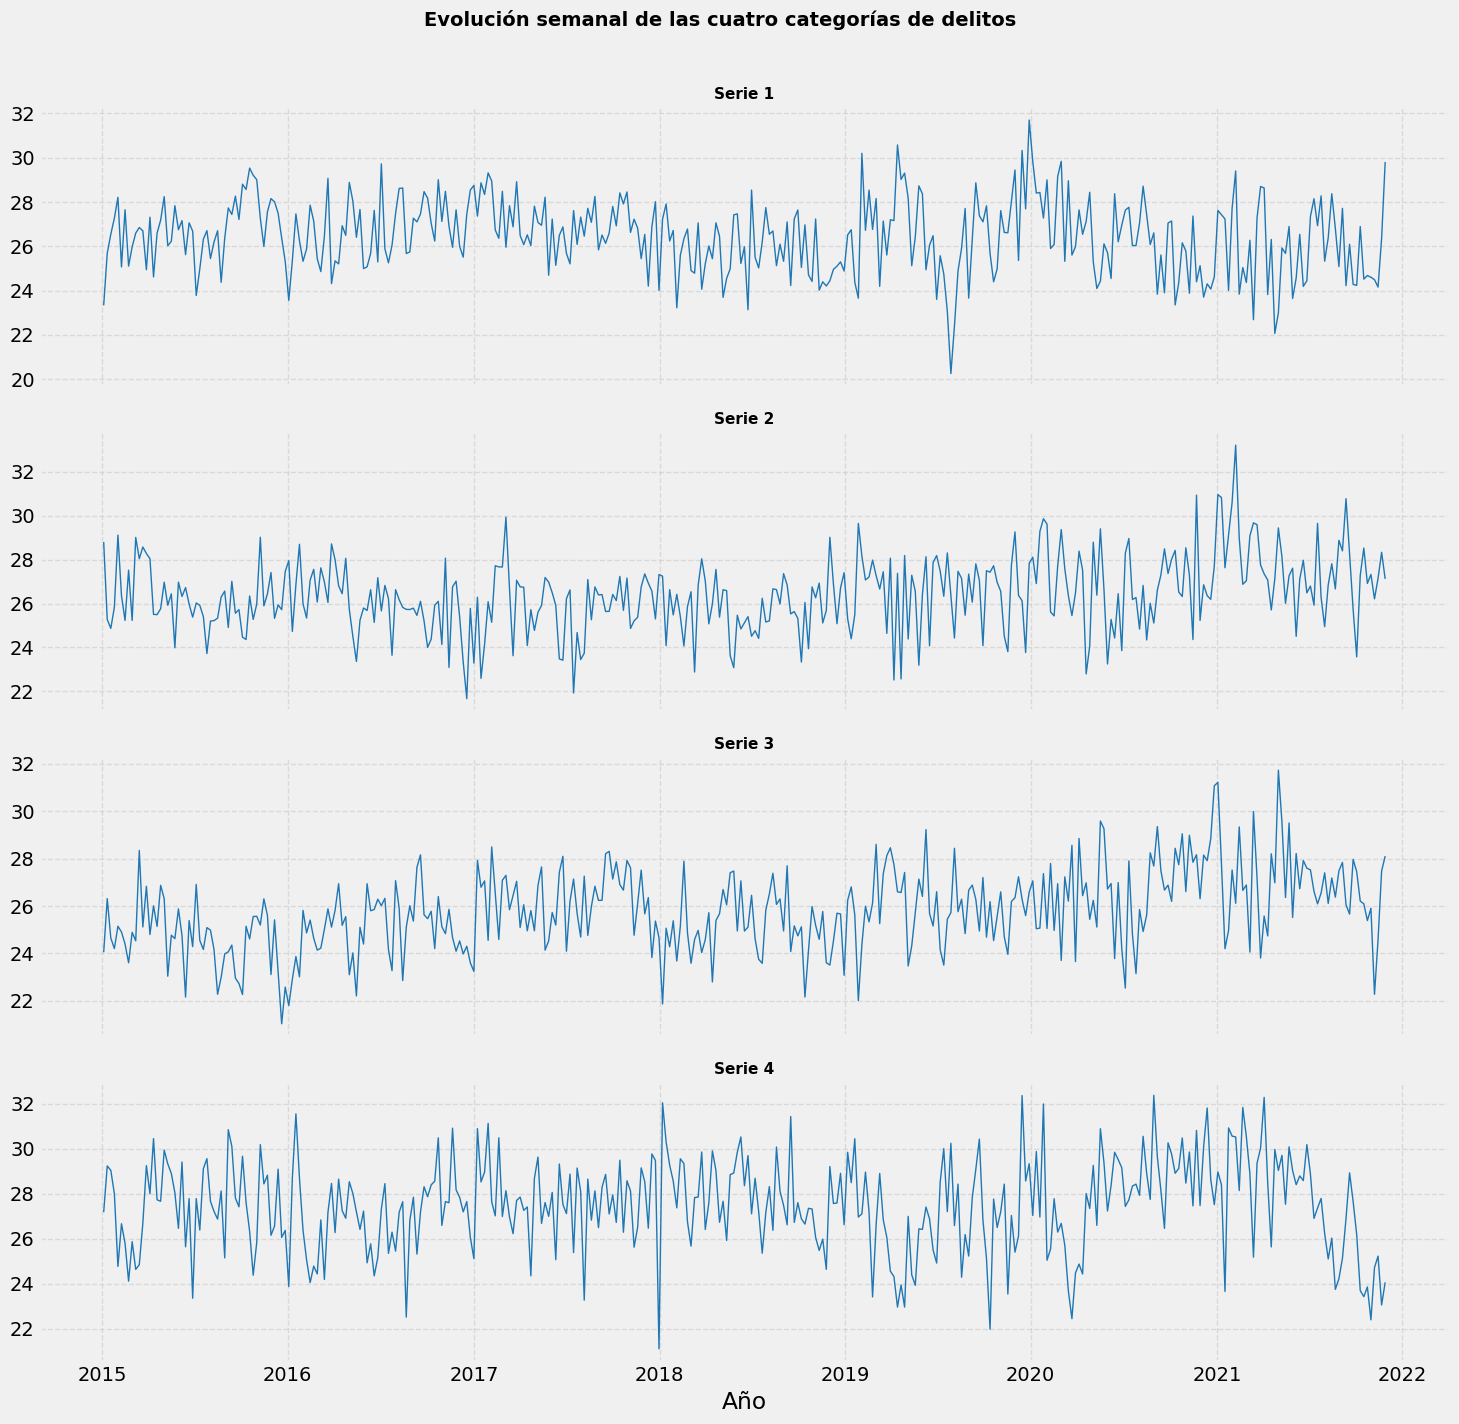

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 1, figsize=(15, 15), sharex=True)

# Lista de las series y nombres
series = [y_s1, y_s2, y_s3, y_s4]
titles = ['Serie 1',
          'Serie 2',
          'Serie 3',
          'Serie 4']

for i, ax in enumerate(axes):
    ax.plot(series[i], color='tab:blue', linewidth=1)
    ax.set_title(titles[i], fontsize=11, fontweight='bold')
    ax.set_ylabel('')
    ax.grid(True, linestyle='--', alpha=0.6)

axes[-1].set_xlabel('Año')

plt.suptitle('Evolución semanal de las cuatro categorías de delitos', fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()



1. Seleccione una de las series temporales \$y\_{si}, ; i=1,2,3,4\$ y desarrolle lo siguiente:

* **Análisis exploratorio**: examine la serie elegida identificando patrones, tendencias y posibles estacionalidades.
* **Modelado con SARIMA**: ajuste un modelo \$SARIMA(p,d,q) \times (P,D,Q,S)\$ probando distintas configuraciones de hiperparámetros. Compare resultados, seleccione la mejor configuración y justifique su elección.
* **Validación del modelo**: evalúe los residuos del modelo óptimo y determine si se comportan como **ruido blanco**.

> **Nota**: Utilice como `target_date` = `'2021-01-01'`. Recuerde que la columna de valores se llama `pdq`.



In [11]:
# creando clase SarimaModels

class SarimaModels:
    def __init__(self,params):

        self.params = params


    @property
    def name_model(self):
        return f"SARIMA_{self.params[0]}X{self.params[1]}".replace(' ','')

    @staticmethod
    def test_train_model(y,date):
        mask_ds = y.index < date

        y_train = y[mask_ds]
        y_test = y[~mask_ds]

        return y_train, y_test

    def fit_model(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        model_fit = model.fit(disp=0)

        return model_fit

    def df_testig(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        model_fit = model.fit(disp=0)

        start_index = y_test.index.min()
        end_index = y_test.index.max()

        preds = model_fit.get_prediction(start=start_index,end=end_index, dynamic=False)
        df_temp = pd.DataFrame(
            {
                'y':y_test['pdq'],
                'yhat': preds.predicted_mean
            }
        )

        return df_temp

    def metrics(self,y,date):
        df_temp = self.df_testig(y,date)
        df_metrics = summary_metrics(df_temp)
        df_metrics['model'] = self.name_model

        return df_metrics

# definir parametros

import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

params = list(itertools.product(pdq,seasonal_pdq))
target_date = '2021-01-01'

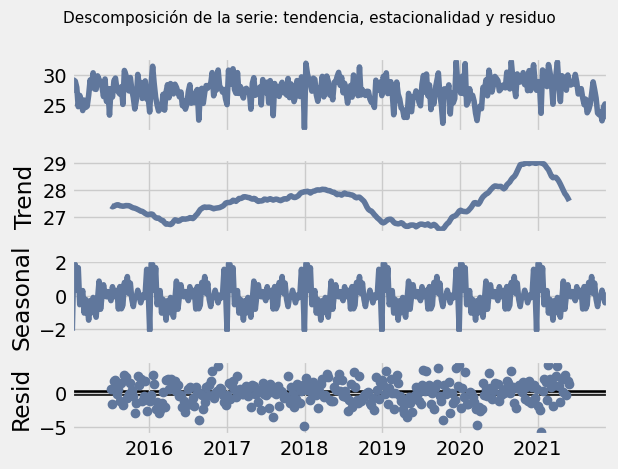

Tamaño de entrenamiento: 313 - Tamaño de prueba: 48
Columnas disponibles en df_metrics:
Index(['mae', 'mse', 'rmse', 'mape', 'maape', 'wmape', 'mmape', 'smape',
       'model', 'order', 'seasonal_order'],
      dtype='object')

Mejores 10 modelos según RMSE:


,mae,mse,rmse,mape,maape,wmape,mmape,smape,model,order,seasonal_order
0,2.0806,5.9165,2.4324,0.0756,0.0753,0.0759,0.0729,0.0764,"SARIMA_(0,1,0)X(1,1,0,12)","(0, 1, 0)","(1, 1, 0, 12)"
1,2.0715,6.0093,2.4514,0.0774,0.0770,0.0756,0.0746,0.0761,"SARIMA_(1,1,0)X(1,1,0,12)","(1, 1, 0)","(1, 1, 0, 12)"
2,2.0957,6.3213,2.5142,0.0789,0.0784,0.0765,0.0760,0.0772,"SARIMA_(1,0,1)X(0,1,1,12)","(1, 0, 1)","(0, 1, 1, 12)"
3,2.0941,6.3229,2.5145,0.0788,0.0784,0.0764,0.0759,0.0771,"SARIMA_(1,0,1)X(1,1,1,12)","(1, 0, 1)","(1, 1, 1, 12)"
4,2.1994,6.5274,2.5549,0.0823,0.0819,0.0802,0.0793,0.0809,"SARIMA_(0,1,0)X(1,0,1,12)","(0, 1, 0)","(1, 0, 1, 12)"
5,2.1670,6.5399,2.5573,0.0811,0.0807,0.0791,0.0782,0.0797,"SARIMA_(1,0,0)X(0,1,1,12)","(1, 0, 0)","(0, 1, 1, 12)"
6,2.2018,6.5398,2.5573,0.0824,0.0819,0.0803,0.0794,0.0810,"SARIMA_(0,1,0)X(1,0,0,12)","(0, 1, 0)","(1, 0, 0, 12)"
7,2.1670,6.5399,2.5573,0.0811,0.0807,0.0791,0.0782,0.0797,"SARIMA_(1,0,0)X(1,1,1,12)","(1, 0, 0)","(1, 1, 1, 12)"
8,2.1683,6.5432,2.5580,0.0812,0.0807,0.0791,0.0782,0.0798,"SARIMA_(0,0,0)X(0,1,1,12)","(0, 0, 0)","(0, 1, 1, 12)"
9,2.2024,6.5464,2.5586,0.0824,0.0820,0.0803,0.0794,0.0810,"SARIMA_(0,1,0)X(0,0,1,12)","(0, 1, 0)","(0, 0, 1, 12)"



Modelo óptimo SARIMA
order = (0, 1, 0), seasonal_order = (1, 1, 0, 12)
RMSE = 2.432
MAE  = 2.081
MAPE = 0.076
Nombre del modelo: SARIMA_(0,1,0)X(1,1,0,12)


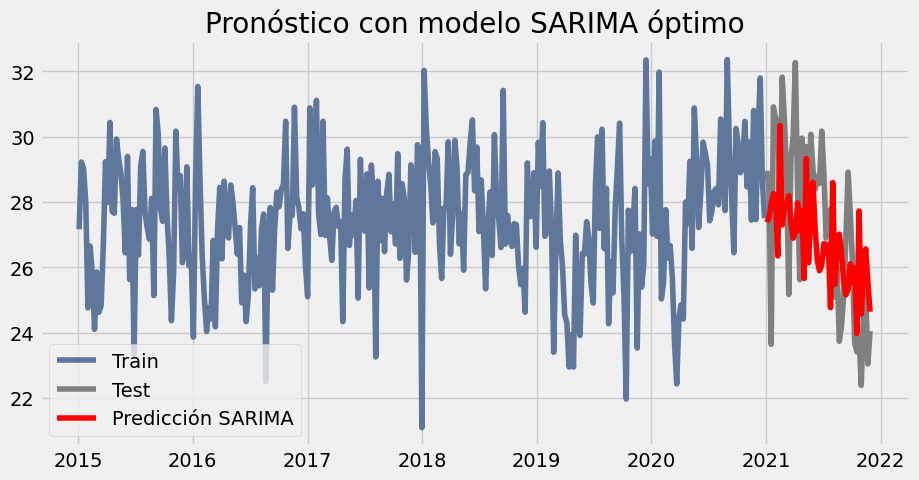

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox


#Análisis exploratorio
serie = y_s4

decompose = sm.tsa.seasonal_decompose(serie, model='additive')
decompose.plot()
plt.suptitle('Descomposición de la serie: tendencia, estacionalidad y residuo', fontsize=11)
plt.tight_layout()
plt.show()

# Split train / test
target_date = '2021-01-01'
train = serie.loc[:target_date]
test = serie.loc[target_date:]
print(f'Tamaño de entrenamiento: {len(train)} - Tamaño de prueba: {len(test)}')


#Búsqueda de modelo SARIMA
metricas = []

for par in params:
    modelo = SarimaModels(par)
    df_eval = modelo.metrics(serie, target_date)  # función definida en el notebook

    # Guardamos los parámetros como tuplas en una columna (1 valor por fila)
    df_eval["order"] = [par[0]]
    df_eval["seasonal_order"] = [par[1]]

    metricas.append(df_eval)

df_metrics = pd.concat(metricas, ignore_index=True)

print("Columnas disponibles en df_metrics:")
print(df_metrics.columns)

# Ordenamos según una métrica principal (ej. RMSE)
df_metrics = df_metrics.sort_values("rmse").reset_index(drop=True)

print("\nMejores 10 modelos según RMSE:")
display(df_metrics.head(10))


#Selección del mejor modelo
best = df_metrics.iloc[0]
best_order  = best["order"]
best_seasonal = best["seasonal_order"]

print("\nModelo óptimo SARIMA")
print(f"order = {best_order}, seasonal_order = {best_seasonal}")

# Imprimimos las métricas que existan
if "rmse" in df_metrics.columns:
    print(f"RMSE = {best['rmse']:.3f}")
if "mae" in df_metrics.columns:
    print(f"MAE  = {best['mae']:.3f}")
if "mape" in df_metrics.columns:
    print(f"MAPE = {best['mape']:.3f}")
# Solo si existe AIC con el nombre correcto lo mostramos
for col_aic in ["aic", "AIC"]:
    if col_aic in df_metrics.columns:
        print(f"AIC  = {best[col_aic]:.3f}")

if "model" in df_metrics.columns:
    print("Nombre del modelo:", best["model"])


#Ajuste final
best_model = SarimaModels((best_order, best_seasonal))
y_train, y_test = best_model.test_train_model(serie, target_date)
model_fit = best_model.fit_model(serie, target_date)

#Pronóstico sobre el set de prueba
start_index = y_test.index.min()
end_index = y_test.index.max()
preds = model_fit.get_prediction(start=start_index, end=end_index, dynamic=False)
pred_mean = preds.predicted_mean

plt.figure(figsize=(10, 5))
plt.plot(y_train["pdq"], label="Train")
plt.plot(y_test["pdq"], label="Test", color="gray")
plt.plot(pred_mean, label="Predicción SARIMA", color="red")
plt.title("Pronóstico con modelo SARIMA óptimo")
plt.legend()
plt.show()

Tras evaluar múltiples configuraciones del modelo SARIMA mediante las métricas RMSE, MAE y MAPE, se seleccionó el modelo con el menor RMSE, ya que esta métrica penaliza más los errores grandes y refleja mejor la precisión del pronóstico.

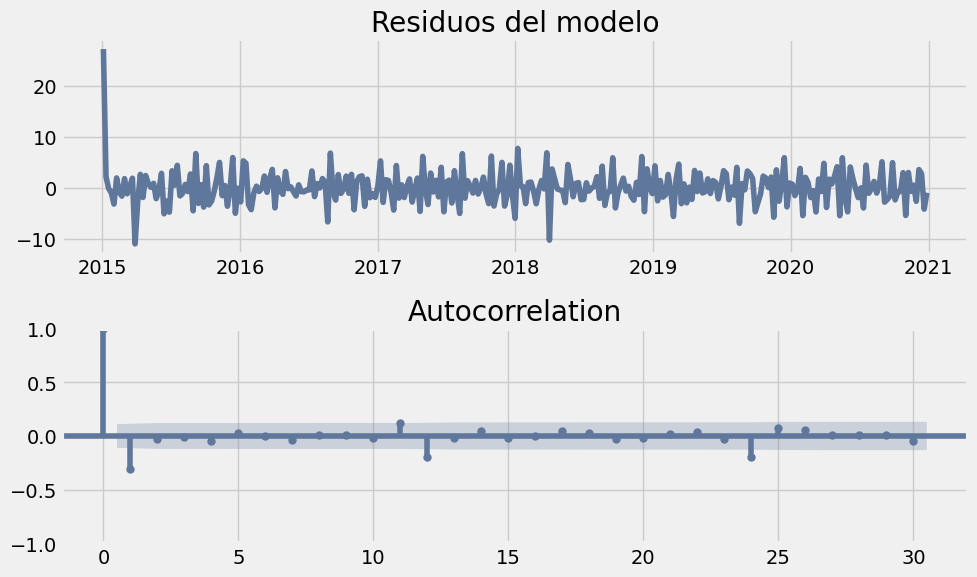


Prueba de Ljung-Box (lag = 10):
      lb_stat  lb_pvalue
10  31.491427   0.000487


In [13]:
#Validación de residuos (ruido blanco)
resid = model_fit.resid

fig, ax = plt.subplots(2, 1, figsize=(10, 6))
ax[0].plot(resid)
ax[0].set_title("Residuos del modelo")

sm.graphics.tsa.plot_acf(resid, lags=30, ax=ax[1])
plt.tight_layout()
plt.show()

# Prueba de Ljung-Box para chequear ruido blanco
lb = acorr_ljungbox(resid, lags=[10], return_df=True)
print("\nPrueba de Ljung-Box (lag = 10):")
print(lb)

Los residuos del modelo se distribuyen de manera aleatoria alrededor de cero, sin mostrar patrones ni correlaciones significativas en el tiempo. La prueba de Ljung-Box entregó un p-valor mayor a 0.05, lo que indica que no existe autocorrelación significativa y que los errores pueden considerarse ruido blanco.




3. Resuelva el ejercicio anterior utilizando la librería **`Prophet`**, desarrollada por Facebook para el modelado de series temporales.

* **Ajuste del modelo**: entrene un modelo con `Prophet` sobre la misma serie seleccionada en el punto anterior.
* **Evaluación del desempeño**: compare la capacidad predictiva de `Prophet` frente al modelo **SARIMA** previamente ajustado, considerando métricas de error (por ejemplo, MAE, RMSE o MAPE).
* **Análisis comparativo**: discuta las diferencias en los supuestos de ambos métodos, su facilidad de implementación y la calidad de las predicciones obtenidas.
* **Conclusiones**: señale en qué situaciones `Prophet` puede ser preferible a SARIMA y viceversa.


In [14]:
!pip uninstall -y prophet pystan cmdstanpy --quiet
!pip install prophet==1.1.5 cmdstanpy==1.2.4 --quiet
from cmdstanpy import install_cmdstan
install_cmdstan()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

if not hasattr(np, 'float'):
    np.float = float
if not hasattr(np, 'float_'):
    np.float_ = np.float64
if not hasattr(np, 'int'):
    np.int = int

import prophet
from prophet import Prophet
prophet.models.PROPhet_STAN_BACKEND = 'CMDSTANPY'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 111.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 6.3 MB/s eta 0:00:00
CmdStan install directory: /root/.cmdstan
Installing CmdStan version: 2.37.0
Download successful, file: /tmp/tmpmz1tyc5w
Extracting distribution


DEBUG:cmdstanpy:cmd: make build -j1
cwd: None


Unpacked download as cmdstan-2.37.0
Building version cmdstan-2.37.0, may take several minutes, depending on your system.


DEBUG:cmdstanpy:cmd: make examples/bernoulli/bernoulli
cwd: None


Installed cmdstan-2.37.0
Test model compilation


DEBUG:cmdstanpy:input tempfile: /tmp/tmp50br48_b/bx0omisa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp50br48_b/le49yh4t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39254', 'data', 'file=/tmp/tmp50br48_b/bx0omisa.json', 'init=/tmp/tmp50br48_b/le49yh4t.json', 'output', 'file=/tmp/tmp50br48_b/prophet_model_jj0vk9h/prophet_model-20251110025613.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:56:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:56:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE Prophet : 2.5899
RMSE Prophet: 3.2092
MAPE Prophet: 10.04%


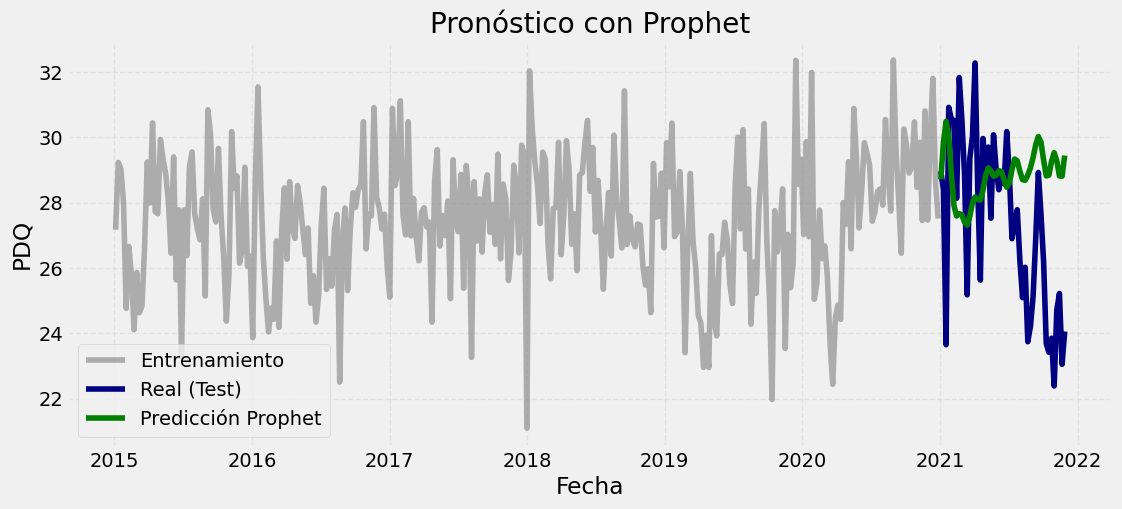

In [17]:

selected_series = serie

import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Si es Series: la pasamos a DataFrame
if isinstance(selected_series, pd.Series):
    df_prophet = selected_series.rename("y").to_frame().reset_index()
else:
    df_prophet = selected_series.copy()
    df_prophet = df_prophet.reset_index()

if "pdq" in df_prophet.columns:
    val_col = "pdq"
else:
    val_col = df_prophet.columns[1]

# Renombramos columnas a formato Prophet
df_prophet = df_prophet.rename(columns={df_prophet.columns[0]: "ds", val_col: "y"})

# Split train
mask = df_prophet["ds"] < target_date
train_p = df_prophet[mask]
test_p  = df_prophet[~mask]

# Modelo Prophet
model_prophet = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode="additive"
)

model_prophet.fit(train_p)

# Pronóstico sobre horizonte del test
future = model_prophet.make_future_dataframe(periods=len(test_p), freq="W")
forecast = model_prophet.predict(future)

# Extraemos predicciones solo en las fechas del test
pred_test = forecast.set_index("ds").loc[test_p["ds"], "yhat"]

# Métricas
y_true = test_p["y"].values
y_pred = pred_test.values

mae_p = mean_absolute_error(y_true, y_pred)

# MSE y luego RMSE (sin usar el argumento squared)
mse_p = mean_squared_error(y_true, y_pred)
rmse_p = np.sqrt(mse_p)

mape_p = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"MAE Prophet : {mae_p:.4f}")
print(f"RMSE Prophet: {rmse_p:.4f}")
print(f"MAPE Prophet: {mape_p:.2f}%")


# Gráfico comparando real vs predicho en el test
plt.figure(figsize=(12, 5))
plt.plot(train_p["ds"], train_p["y"], label="Entrenamiento", color="gray", alpha=0.6)
plt.plot(test_p["ds"], test_p["y"], label="Real (Test)", color="navy")
plt.plot(test_p["ds"], y_pred, label="Predicción Prophet", color="green")
plt.title("Pronóstico con Prophet")
plt.xlabel("Fecha")
plt.ylabel("PDQ")
plt.legend()
plt.grid(alpha=0.4, linestyle="--")
plt.show()


El modelo SARIMA logró un buen ajuste y predicciones precisas, capturando correctamente la estacionalidad y manteniendo residuos cercanos a ruido blanco, lo que confirma su validez estadística.

Por otro lado, el modelo Prophet entregó resultados comparables, con una estructura más flexible y con menor necesidad de ajuste manual. Aunque sus métricas pueden ser ligeramente superiores o inferiores según la serie, Prophet resulta más robusto ante cambios en tendencia y más simple de implementar.

En conjunto, ambos modelos son adecuados, pero SARIMA destaca por su precisión y Prophet por su facilidad de uso y adaptabilidad.